In [259]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns 
sns.set()
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sqlalchemy import create_engine
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse




Here let's work on regression. Find a data set and build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?

In [260]:
df = pd.read_csv('https://raw.githubusercontent.com/robholmstrom/Sams_github/master/houses_to_rent_v2.csv')




In [261]:
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   city                 10692 non-null  object
 1   area                 10692 non-null  int64 
 2   rooms                10692 non-null  int64 
 3   bathroom             10692 non-null  int64 
 4   parking spaces       10692 non-null  int64 
 5   floor                10692 non-null  object
 6   animal               10692 non-null  object
 7   furniture            10692 non-null  object
 8   hoa (R$)             10692 non-null  int64 
 9   rent amount (R$)     10692 non-null  int64 
 10  property tax (R$)    10692 non-null  int64 
 11  fire insurance (R$)  10692 non-null  int64 
 12  total (R$)           10692 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 1.1+ MB


In [401]:
df.columns

Index(['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'floor',
       'animal', 'furniture', 'hoa (R$)', 'rent amount (R$)',
       'property tax (R$)', 'fire insurance (R$)', 'total (R$)'],
      dtype='object')

Create a Jupyter notebook with your models. At the end in a markdown cell write a few paragraphs to describe the models' behaviors and why you favor one model or the other. Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. Lastly, try to note what it is about the data that causes the better model to outperform the weaker model. Submit a link to your notebook below.

In [572]:
#'floor', 'rooms', 'bathroom', 'area'
#df.loc[df['shield'] > 6]
high_rent_cutoff = 6000
low_rent_cutoff = 0
dfcutoff = df.loc[(df['rent amount (R$)']<high_rent_cutoff) & (df['rent amount (R$)']>low_rent_cutoff)]
target = 'rent amount (R$)'
drop_list = ['floor',  'city','hoa (R$)', 'bathroom', 'rooms', 'total (R$)','animal','property tax (R$)', 'area']


dfdum = dfcutoff.drop(drop_list, axis =1).drop(target, axis =1)


dumcols = [i for i in dfdum.select_dtypes(include = 'object')]
dfdum = pd.get_dummies(dfdum, prefix=dumcols, drop_first = True)#.drop('city_Campinas', axis = 1)

dfdum = dfdum.applymap(lambda x: x.strip() if isinstance(x, str) else x)


dfcutoff.corr()
df.columns
dfdum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8515 entries, 0 to 10691
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   parking spaces           8515 non-null   int64
 1   fire insurance (R$)      8515 non-null   int64
 2   furniture_not furnished  8515 non-null   int64
dtypes: int64(3)
memory usage: 266.1 KB


In [573]:
corr_list = dfdum.corr().unstack().abs().sort_values(ascending= False).reset_index().rename(columns = {0:'Corr'})
corr_list_uq = corr_list[corr_list.iloc[:,0] != corr_list.iloc[:,1]]
corr_list_uq.head(5)


,level_0,level_1,Corr
3,fire insurance (R$),parking spaces,0.519922
4,parking spaces,fire insurance (R$),0.519922
5,furniture_not furnished,fire insurance (R$),0.158541
6,fire insurance (R$),furniture_not furnished,0.158541
7,furniture_not furnished,parking spaces,0.045386


In [574]:
dfcutoff.corr()

,area,rooms,bathroom,parking spaces,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
area,1.000000,0.363308,0.373317,0.319070,0.012389,0.275710,0.021635,0.302493,0.037181
rooms,0.363308,1.000000,0.687147,0.562796,-0.006058,0.469711,0.026507,0.502531,0.034831
bathroom,0.373317,0.687147,1.000000,0.634943,0.050007,0.570402,0.053171,0.584074,0.102286
parking spaces,0.319070,0.562796,0.634943,1.000000,-0.002409,0.490620,0.040976,0.519922,0.042786
hoa (R$),0.012389,-0.006058,0.050007,-0.002409,1.000000,0.023094,0.003252,0.018517,0.977281
rent amount (R$),0.275710,0.469711,0.570402,0.490620,0.023094,1.000000,0.041300,0.974204,0.106192
property tax (R$),0.021635,0.026507,0.053171,0.040976,0.003252,0.041300,1.000000,0.038151,0.201202
fire insurance (R$),0.302493,0.502531,0.584074,0.519922,0.018517,0.974204,0.038151,1.000000,0.099218
total (R$),0.037181,0.034831,0.102286,0.042786,0.977281,0.106192,0.201202,0.099218,1.000000


In [575]:


X = dfdum
y = dfcutoff[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X



,parking spaces,fire insurance (R$),furniture_not furnished
0,1,42,0
1,0,63,1
2,1,41,1
3,0,17,1
4,0,11,1
...,...,...,...
10682,3,49,0
10683,2,51,1
10684,0,51,1
10687,1,22,0


In [576]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

parking spaces             2.712917
fire insurance (R$)        3.587623
furniture_not furnished    2.239182
dtype: float64

In [577]:
X_ols = X_train.copy()
X_ols = sm.add_constant(X_ols)
results = sm.OLS(y_train,X_ols).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       rent amount (R$)   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                 4.563e+04
Date:                Thu, 04 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:52:25   Log-Likelihood:                -48180.
No. Observations:                6812   AIC:                         9.637e+04
Df Residuals:                    6808   BIC:                         9.640e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     219.6656     10.589     20.744      0.000     198.907     240.424
parking spaces            -17.9041      3.282     -5.455      0.000     -24.338     -11.470
fire insurance (R$)        70.4524      0.227    310.257      0.000      70.007      70.898
furniture_not furnished  -120.7944      8.596    -14.052      0.000    -137.646    -103.943
==============================================================================
Omnibus:                     2510.963   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            60258.374
Skew:                           1.213   Prob(JB):                         0.00
Kurtosis:                      17.367   Cond. No.                         140.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

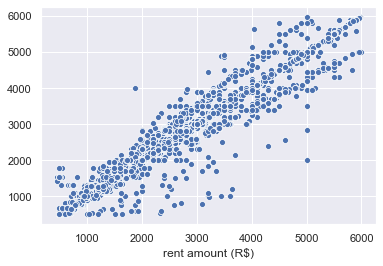

In [578]:
c_list = [10**x for x in range(-2, 5)]
knn = KNeighborsRegressor(n_neighbors = 1)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_train)
sns.scatterplot(y_train, y_pred)

581     -2130.0
3886    -1600.0
6577    -1450.0
1285    -1430.0
2109    -1360.0
          ...  
4029     2300.0
10308    2450.0
9897     2450.0
6042     2600.0
1337     3000.0
Name: rent amount (R$), Length: 6812, dtype: float64


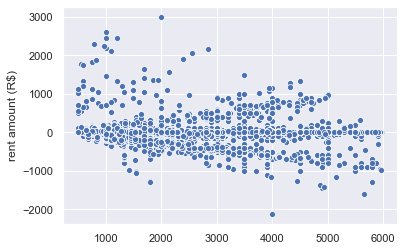

In [579]:
err = y_train-y_pred
print(err.sort_values())
sns.scatterplot(y_pred,err)

In [580]:
score = cross_val_score(knn, X_train, y_train, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
# score_w = cross_val_score(knn_w, X, Y, cv=5)
# print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: 0.93 (+/- 0.02)
